## PyTorch 编写误差反向传播BP的多层感知器MLP处理NIST

In [1]:

from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, data_home=".")  


D:\Program\anaconda\envs\pytorch\lib\site-packages\sklearn\datasets\_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [2]:

#归一化为0-1
X = mnist.data / 255  
y = mnist.target
print(X)

import numpy as np
X = np.array(X)
y = np.array(y)
y = y.astype(np.int32)


       pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  pixel9  \
0         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
1         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
3         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
4         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
...       ...     ...     ...     ...     ...     ...     ...     ...     ...   
69995     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
69996     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
69997     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
69998     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
69999     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

       pixel10  ...  pixel7

该图像的标签是5


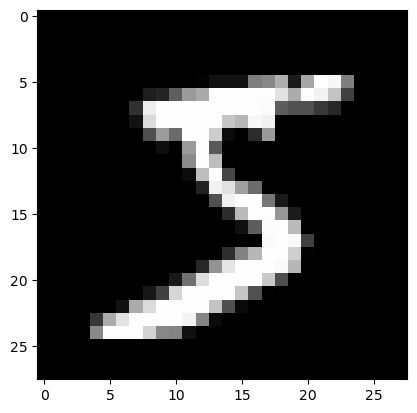

In [3]:

import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(X[0].reshape(28, 28), cmap='gray')
print("该图像的标签是{:.0f}".format(y[0]))


In [4]:

import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

# 2.1 按（6:1）分离训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=1/7, random_state=0)

# 2.2 PyTorch Tensor转换
X_train = torch.Tensor(X_train)
X_test = torch.Tensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

# 2.3 使用数据和标签合成Dataset
ds_train = TensorDataset(X_train, y_train)
ds_test = TensorDataset(X_test, y_test)

# 2.4 使用小批量数据作为Dataloader
loader_train = DataLoader(ds_train, batch_size=64, shuffle=True)
loader_test = DataLoader(ds_test, batch_size=64, shuffle=False)


In [ ]:
# 3. 神经网络建模
# Keras风格

from torch import nn

model = nn.Sequential()
model.add_module('fc1', nn.Linear(28*28*1, 100))
model.add_module('relu1', nn.ReLU())
model.add_module('fc2', nn.Linear(100, 100))
model.add_module('relu2', nn.ReLU())
model.add_module('fc3', nn.Linear(100, 10))

print(model)


In [ ]:
# 4. 设置误差函数、优化器

from torch import optim

loss_fn = nn.CrossEntropyLoss()  

optimizer = optim.Adam(model.parameters(), lr=0.01)


In [ ]:
# 5. 设置训练和推理
# 5-1. 定义每轮训练中所作的工作


def train(epoch):
    model.train()  # 将网络切换到训练模式

    #从dataloader取小批量数据进行训练
    for data, targets in loader_train:
      
        optimizer.zero_grad()  # 优化器的梯度初始化为0
        outputs = model(data)  # 输入数据data，生成输出outputs
        loss = loss_fn(outputs, targets)  # 根据实际输出outputs与期望输出（标签）targets的差异，计算误差损失loss
        loss.backward()  # 对误差进行反向传播
        optimizer.step()  # 更新权重参数

    print("epoch{}：结束\n".format(epoch))


In [ ]:
# 5. 设置训练和推理
# 5-2. 定义推理时所作的工作


def test():
    model.eval()  # 将网络切换到测试模式
    correct = 0   #正确结果计数器初始化为0

    #从dataloader取小批量数据进行测试
    with torch.no_grad():  # 不对误差进行反向传播
        for data, targets in loader_test:

            outputs = model(data)  # 输入数据data，生成输出outputs

            # 推理预测
            _, predicted = torch.max(outputs.data, 1)  # 找到概率最高的标签
            correct += predicted.eq(targets.data.view_as(predicted)).sum()  # 如果实际输出结果predicted和期望输出targets一致，则计数加一

    # 输出准确率
    data_num = len(loader_test.dataset)  # 数据总数
    print('\n测试数据的准确率: {}/{} ({:.0f}%)\n'.format(correct,
                                                   data_num, 100. * correct / data_num))


In [ ]:
# 未学习先测试看看初始准确率
test()


In [ ]:
# 6. 训练后再测试看看准确率
for epoch in range(3):
    train(epoch)

test()


In [ ]:
# 测试第2018张图像

index = 2018

model.eval()  # 将网络切换到测试模式
data = X_test[index]
output = model(data)  # 输入数据data，生成输出outputs
_, predicted = torch.max(output.data, 0)  # 找到概率最高的标签

print("预测结果为{}".format(predicted))

X_test_show = (X_test[index]).numpy()
plt.imshow(X_test_show.reshape(28, 28), cmap='gray')
print("该图像的正确标签是{:.0f}です".format(y_test[index]))


In [12]:
#-----------------------------------------------

In [13]:
# 3. 神经网络建模
#    类定义风格
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):

    def __init__(self, n_in, n_mid, n_out):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(n_in, n_mid)  
        self.fc2 = nn.Linear(n_mid, n_mid)
        self.fc3 = nn.Linear(n_mid, n_out)

    def forward(self, x):
        
        h1 = F.relu(self.fc1(x))
        h2 = F.relu(self.fc2(h1))
        output = self.fc3(h2)
        return output


model = Net(n_in=28*28*1, n_mid=100, n_out=10)  
print(model)


Net(
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=10, bias=True)
)


In [23]:
a = torch.ones((2,2),requires_grad=True)
b = a.pow(2).sum()
b.backward(retain_graph=True)

In [24]:
a.grad

tensor([[2., 2.],
        [2., 2.]])

In [26]:
b.backward(retain_graph=True)

In [27]:
a.grad

tensor([[4., 4.],
        [4., 4.]])

In [28]:
b.backward()
a.grad

tensor([[6., 6.],
        [6., 6.]])

In [29]:
a.data.cpu().numpy()

array([[1., 1.],
       [1., 1.]], dtype=float32)

In [30]:
a.cpu().data.numpy()

array([[1., 1.],
       [1., 1.]], dtype=float32)

In [31]:
a.detach().cpu().numpy()

array([[1., 1.],
       [1., 1.]], dtype=float32)